In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pylab as plt

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
from keras.layers import Dropout

In [2]:
data_file = 'taiex_2012-2021.xlsx'
df = pd.read_excel(data_file)
df.head()

,時間,開盤價,最高價,最低價,收盤價,成交量
0,2012-01-03,7005.390137,7073.790039,7005.390137,7053.379883,641.39
1,2012-01-04,7093.069824,7116.220215,7064.580078,7082.970215,758.46
2,2012-01-05,7099.350098,7130.859863,7073.319824,7130.859863,768.51
3,2012-01-06,7129.529785,7139.040039,7090.470215,7120.509766,881.02
4,2012-01-09,7103.089844,7103.089844,7050.250000,7093.040039,713.23


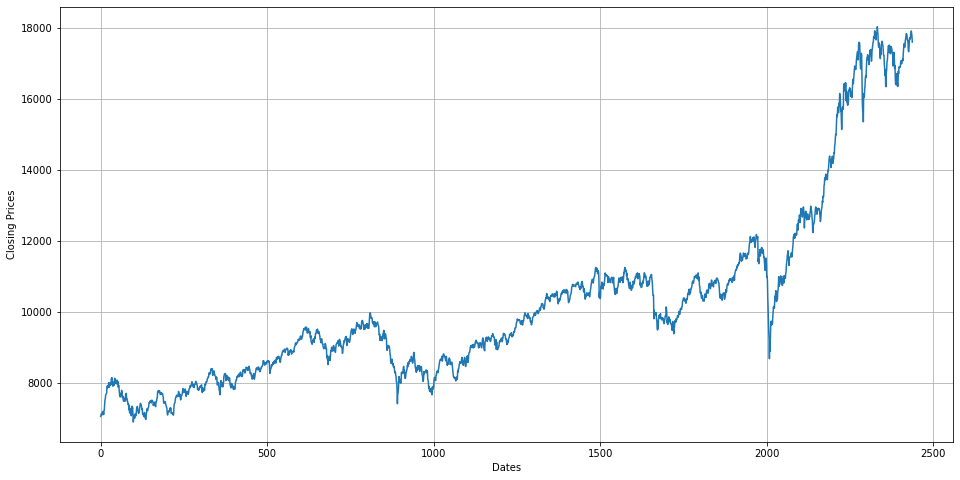

In [3]:
data = pd.read_excel(data_file, converters= {'時間': pd.to_datetime})
plt.figure(figsize=(16,8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(data['收盤價']);

In [4]:
train_start_idx = 0
train_end_idx = -478

print('Training data range: ', df.iloc[train_start_idx]['時間'], ' - ', df.iloc[train_end_idx]['時間'])

Training data range:  2012-01-03 00:00:00  -  2019-12-31 00:00:00


In [5]:
train_data = df[train_start_idx:train_end_idx].drop(columns=['時間']).to_numpy()
test_data = df[-train_end_idx:].drop(columns=['時間']).to_numpy()
print(df.iloc[train_start_idx])
print("\n **** Convert stock data into numpy tensor ****")
print(train_data[0])

時間     2012-01-03 00:00:00
開盤價            7005.390137
最高價            7073.790039
最低價            7005.390137
收盤價            7053.379883
成交量                 641.39
Name: 0, dtype: object

 **** Convert stock data into numpy tensor ****
[7005.390137 7073.790039 7005.390137 7053.379883  641.39    ]


In [6]:
def generator(data, lookback, delay, min_index=0, max_index=None, shuffle=False, 
              batch_size=128, step=1, target_index=-2, normalize=True):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            if normalize:
                norm = data[rows[j] - lookback]
                samples[j] = data[indices] / norm
                targets[j] = data[rows[j] + delay][target_index] / norm[target_index]
            else:
                samples[j] = data[indices]
                targets[j] = data[rows[j] + delay][target_index]
        yield samples, targets

In [7]:
lookback = 20 
step = 1
delay = 30 
batch_size = 10 
target_idx = 3
num_val_data = 100 

train_gen = generator(train_data[0: ],
                      lookback=lookback,
                      delay=delay,
                      max_index= len(train_data) - num_val_data - 1,
                      step=step, 
                      normalize=True,
                      target_index = target_idx,
                      batch_size=batch_size)

val_gen = generator(train_data,
                      lookback=lookback,
                      delay=delay,
                      step=step, 
                      min_index= len(train_data) - num_val_data,
                      normalize=True,
                      target_index = target_idx,
                      batch_size=batch_size)

val_steps = (num_val_data - lookback) // batch_size

In [8]:
for samples, targets in train_gen:
    print(samples)
    print(targets)
    break

[[[1.         1.         1.         1.         1.        ]
  [1.01251603 1.00599822 1.0084492  1.0041952  1.18252545]
  [1.01341252 1.00806779 1.00969677 1.0109848  1.19819455]
  [1.01772059 1.00922419 1.01214495 1.00951741 1.37361044]
  [1.01394636 1.00414202 1.00640362 1.00562286 1.11200674]
  [1.01762496 1.01526059 1.01762496 1.0177915  1.51497529]
  [1.02822255 1.01958919 1.02555029 1.01911567 1.38429037]
  [1.02811974 1.01921886 1.02405005 1.01888459 1.23088916]
  [1.03152574 1.02490177 1.02348617 1.01817003 1.54798173]
  [1.03376397 1.02615992 1.01227055 1.00712286 1.19806982]
  [1.01981475 1.02082194 1.01612611 1.02377586 1.57677856]
  [1.03285326 1.02422179 1.02700202 1.02556364 1.77721823]
  [1.05386282 1.05219829 1.05386282 1.050193   2.24358035]
  [1.06154259 1.06266655 1.05932855 1.06574156 2.53139276]
  [1.0735105  1.06959353 1.06902971 1.07029681 2.27649324]
  [1.0868474  1.08180479 1.08184692 1.08493518 2.60727482]
  [1.09325534 1.08498983 1.08607943 1.08812943 2.3963423

In [9]:
from keras.models import Sequential
from keras import layers

model = Sequential()
model.add(layers.GRU(16, input_shape=(None, train_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer='RMSprop', loss='mae')
history = model.fit_generator(train_gen, 
                            steps_per_epoch=1000, epochs=30,
                            validation_data=val_gen,
                            validation_steps=val_steps)

<ipython-input-9-4a69c8a59c81>:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,


Epoch 1/30
1000/1000 [==============================] - 9s 7ms/step - loss: 0.0389 - val_loss: 0.1793
Epoch 2/30
1000/1000 [==============================] - 7s 7ms/step - loss: 0.0287 - val_loss: 0.0144
Epoch 3/30
1000/1000 [==============================] - 7s 7ms/step - loss: 0.0279 - val_loss: 0.0125
Epoch 4/30
1000/1000 [==============================] - 7s 7ms/step - loss: 0.0281 - val_loss: 0.0875
Epoch 5/30
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0284 - val_loss: 0.0783
Epoch 6/30
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0285 - val_loss: 0.0411
Epoch 7/30
1000/1000 [==============================] - 7s 7ms/step - loss: 0.0290 - val_loss: 0.0665
Epoch 8/30
1000/1000 [==============================] - 7s 7ms/step - loss: 0.0293 - val_loss: 0.0244
Epoch 9/30
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0292 - val_loss: 0.1011
Epoch 10/30
1000/1000 [==============================] - 6s 6ms/step - loss: 0.029

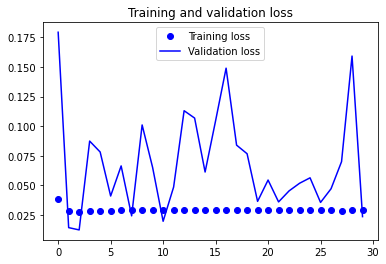

In [10]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [11]:
test_gen = generator(test_data,
                      lookback=lookback,
                      delay=delay,
                      step=step, 
                      normalize=True,
                      target_index = target_idx,
                      batch_size=batch_size)

In [12]:
model.evaluate_generator(test_gen, len(test_data))

<ipython-input-12-0e4958bf8255>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(test_gen, len(test_data))


0.05127236619591713

In [13]:
prices = df.iloc[-lookback:].drop(columns=['時間']).to_numpy()
x = prices / prices[0]
price_sample = np.expand_dims(x, axis=0)
pred = model.predict(price_sample)

pred_price = pred[0][0]*prices[0][target_idx]

print('The TAIEX price for ', str(delay) ,' trading days after ', df.iloc[-1]['時間'], ' is ' + str(pred_price))

The TAIEX price for  30  trading days after  2021-12-14 00:00:00  is 18551.259439239504
